# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 100)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 100)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 100)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 2000)             8000      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               200100    
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 50)                1300      
                                                        

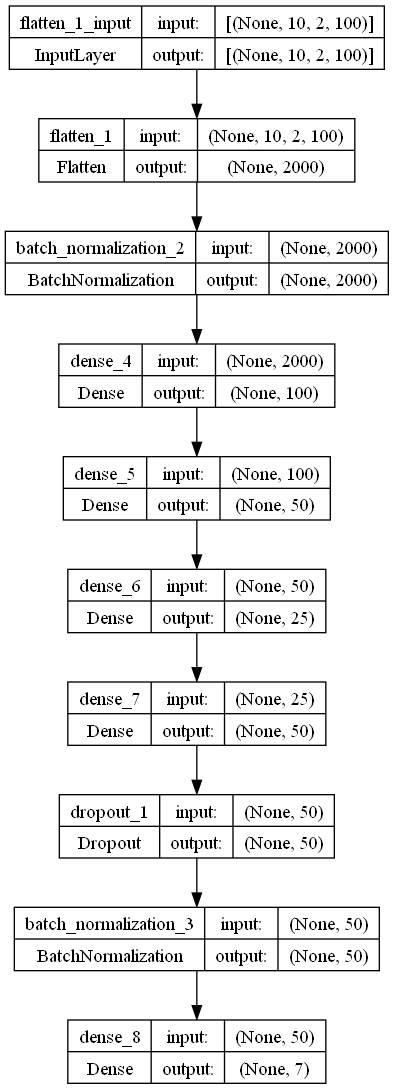

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=10.0)

In [27]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, 
                    callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 1s 1ms/step - loss: 13.9339 - mae: 2.4129 - val_loss: 11.2232 - val_mae: 2.2147 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 1s 1ms/step - loss: 10.2968 - mae: 2.2076 - val_loss: 8.7948 - val_mae: 2.0162 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 1s 1ms/step - loss: 9.0999 - mae: 2.1557 - val_loss: 8.4855 - val_mae: 2.0426 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 1s 1ms/step - loss: 8.7130 - mae: 2.1356 - val_loss: 8.0453 - val_mae: 2.0151 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 1s 1ms/step - loss: 8.3884 - mae: 2.1211 - val_loss: 8.3058 - val_mae: 2.0747 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 1s 1ms/step - loss: 8.2285 - mae: 2.1039 - val_loss: 7.8902 - val_mae: 2.0298 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 1s 1ms/step - loss: 7.9817 - mae: 2.0868 - val_loss: 7.2333

700/700 [==============================] - 1s 1ms/step - loss: 5.4789 - mae: 1.7991 - val_loss: 4.7307 - val_mae: 1.5962 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4846 - mae: 1.8007 - val_loss: 4.8371 - val_mae: 1.6288 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.5058 - mae: 1.8052 - val_loss: 4.8572 - val_mae: 1.6420 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.5030 - mae: 1.8068 - val_loss: 4.7373 - val_mae: 1.5923 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.5227 - mae: 1.8045 - val_loss: 4.8443 - val_mae: 1.6124 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.5267 - mae: 1.8065 - val_loss: 4.9151 - val_mae: 1.6538 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.5081 - mae: 1.8079 - val_loss: 4.7990 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.4302 - mae: 1.7872 - val_loss: 4.6023 - val_mae: 1.5758 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4514 - mae: 1.7964 - val_loss: 4.7127 - val_mae: 1.6055 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4481 - mae: 1.7944 - val_loss: 4.6986 - val_mae: 1.5867 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4012 - mae: 1.7857 - val_loss: 4.7874 - val_mae: 1.6117 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4222 - mae: 1.7944 - val_loss: 4.6609 - val_mae: 1.5882 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4317 - mae: 1.7929 - val_loss: 4.6089 - val_mae: 1.5715 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4047 - mae: 1.7842 - val_loss: 4.7102 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.4396 - mae: 1.7923 - val_loss: 4.6855 - val_mae: 1.5816 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3682 - mae: 1.7796 - val_loss: 4.6914 - val_mae: 1.5842 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3887 - mae: 1.7850 - val_loss: 4.7768 - val_mae: 1.6089 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4015 - mae: 1.7897 - val_loss: 4.7295 - val_mae: 1.6036 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4144 - mae: 1.7901 - val_loss: 4.6310 - val_mae: 1.5671 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4111 - mae: 1.7912 - val_loss: 4.7508 - val_mae: 1.6046 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4493 - mae: 1.7928 - val_loss: 4.6836 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.4156 - mae: 1.7890 - val_loss: 4.7213 - val_mae: 1.6018 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3543 - mae: 1.7738 - val_loss: 4.6663 - val_mae: 1.5865 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3700 - mae: 1.7780 - val_loss: 4.6525 - val_mae: 1.5929 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3732 - mae: 1.7835 - val_loss: 4.5732 - val_mae: 1.5529 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3978 - mae: 1.7878 - val_loss: 4.7392 - val_mae: 1.5972 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.4037 - mae: 1.7854 - val_loss: 4.6076 - val_mae: 1.5545 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3723 - mae: 1.7763 - val_loss: 4.7827 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.4165 - mae: 1.7857 - val_loss: 4.7168 - val_mae: 1.5853 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3915 - mae: 1.7792 - val_loss: 4.6875 - val_mae: 1.5841 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3755 - mae: 1.7787 - val_loss: 4.7053 - val_mae: 1.5853 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3644 - mae: 1.7734 - val_loss: 4.7444 - val_mae: 1.5852 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3625 - mae: 1.7751 - val_loss: 4.7046 - val_mae: 1.5967 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3723 - mae: 1.7773 - val_loss: 4.6346 - val_mae: 1.5723 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3822 - mae: 1.7832 - val_loss: 4.6787 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.3880 - mae: 1.7810 - val_loss: 4.7852 - val_mae: 1.6074 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3724 - mae: 1.7747 - val_loss: 4.9251 - val_mae: 1.6200 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3836 - mae: 1.7773 - val_loss: 4.7343 - val_mae: 1.5937 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3847 - mae: 1.7778 - val_loss: 4.7609 - val_mae: 1.5989 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3847 - mae: 1.7830 - val_loss: 4.6486 - val_mae: 1.5676 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3823 - mae: 1.7807 - val_loss: 4.5958 - val_mae: 1.5580 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3543 - mae: 1.7754 - val_loss: 4.7435 - v

700/700 [==============================] - 1s 1ms/step - loss: 5.3210 - mae: 1.7662 - val_loss: 4.6498 - val_mae: 1.5732 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3463 - mae: 1.7731 - val_loss: 4.6614 - val_mae: 1.5943 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3286 - mae: 1.7703 - val_loss: 4.6545 - val_mae: 1.5666 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3476 - mae: 1.7698 - val_loss: 4.6768 - val_mae: 1.6118 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3460 - mae: 1.7707 - val_loss: 4.7459 - val_mae: 1.5788 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3251 - mae: 1.7668 - val_loss: 4.6293 - val_mae: 1.5607 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3380 - mae: 1.771

Epoch 494/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3275 - mae: 1.7737 - val_loss: 4.6451 - val_mae: 1.5688 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3151 - mae: 1.7697 - val_loss: 4.6507 - val_mae: 1.5730 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2903 - mae: 1.7635 - val_loss: 4.6138 - val_mae: 1.5834 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2996 - mae: 1.7642 - val_loss: 4.7017 - val_mae: 1.5922 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3095 - mae: 1.7656 - val_loss: 4.7025 - val_mae: 1.5802 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.3190 - mae: 1.7681 - val_loss: 4.6188 - val_mae: 1.5681 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.32

Epoch 601/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2834 - mae: 1.7639 - val_loss: 4.6651 - val_mae: 1.5733 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2829 - mae: 1.7637 - val_loss: 4.7090 - val_mae: 1.5730 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2282 - mae: 1.7540 - val_loss: 4.5612 - val_mae: 1.5625 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2377 - mae: 1.7548 - val_loss: 4.7595 - val_mae: 1.5999 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2659 - mae: 1.7610 - val_loss: 4.6803 - val_mae: 1.5886 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2505 - mae: 1.7579 - val_loss: 4.5638 - val_mae: 1.5562 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.24

Epoch 708/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1812 - mae: 1.7475 - val_loss: 4.6304 - val_mae: 1.5609 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2058 - mae: 1.7521 - val_loss: 4.7051 - val_mae: 1.5957 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2015 - mae: 1.7486 - val_loss: 4.5521 - val_mae: 1.5600 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1802 - mae: 1.7480 - val_loss: 4.5667 - val_mae: 1.5580 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2126 - mae: 1.7507 - val_loss: 4.6057 - val_mae: 1.5798 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.2268 - mae: 1.7541 - val_loss: 4.5896 - val_mae: 1.5823 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.16

Epoch 815/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1422 - mae: 1.7406 - val_loss: 4.5538 - val_mae: 1.5701 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1274 - mae: 1.7379 - val_loss: 4.5598 - val_mae: 1.5814 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1072 - mae: 1.7323 - val_loss: 4.5751 - val_mae: 1.5716 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1500 - mae: 1.7427 - val_loss: 4.5423 - val_mae: 1.5626 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1362 - mae: 1.7416 - val_loss: 4.6968 - val_mae: 1.5965 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.1374 - mae: 1.7394 - val_loss: 4.5907 - val_mae: 1.5789 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.12

Epoch 922/1000
700/700 [==============================] - 1s 1ms/step - loss: 5.0736 - mae: 1.7286 - val_loss: 4.6483 - val_mae: 1.5875 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.0681 - mae: 1.7282 - val_loss: 4.5728 - val_mae: 1.5743 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.0658 - mae: 1.7260 - val_loss: 4.5503 - val_mae: 1.5667 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.0795 - mae: 1.7300 - val_loss: 4.6094 - val_mae: 1.5822 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.0895 - mae: 1.7330 - val_loss: 4.5259 - val_mae: 1.5650 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.1014 - mae: 1.7332 - val_loss: 4.5473 - val_mae: 1.5654 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 1s 2ms/step - loss: 5.11

# Analizamos accuracy y loss

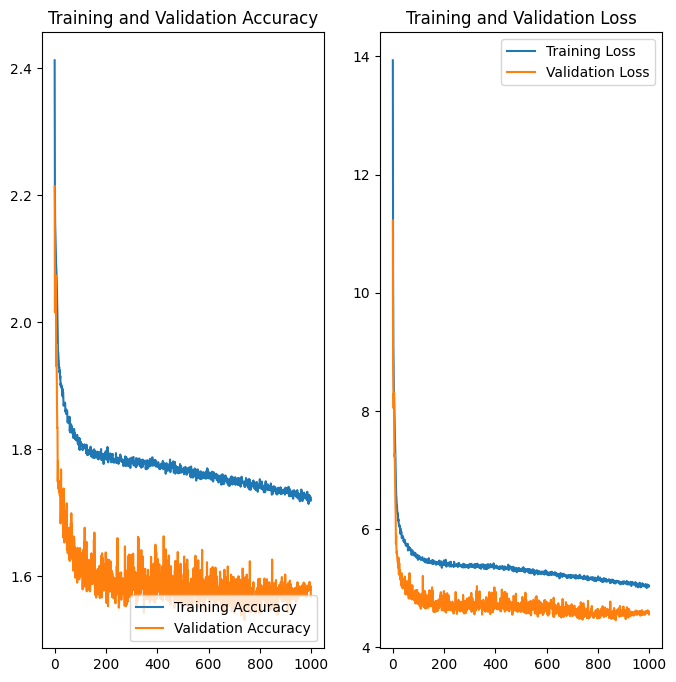

In [30]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [31]:
test_loss, test_acc = model.evaluate(varfval,coefvarfval)

32/32 [==============================] - 0s 936us/step - loss: 4.5584 - mae: 1.5679


In [32]:
predictions = model.predict(varfval)

32/32 [==============================] - 0s 742us/step


In [33]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarfval, predictions)

# Calcula la desviación estándar del error
error = coefvarfval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.5679371577886327, Desviación estándar del error: 2.088527038845989, Error absoluto máximo: 7.608871936798096


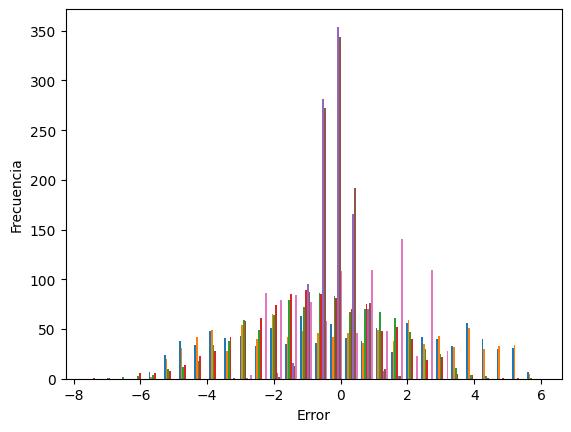

In [34]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [35]:
from sklearn.metrics import r2_score
r2 = r2_score(coefvarfval, predictions)
r2

0.4627590964826803

In [36]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

3.784116816520691

# Guardamos los datos Accuracy y Loss

In [37]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 50,100/historytrayec100.csv', index=False)

# Guardamos el modelo

In [38]:
path_to_save = '../../../Modelos con ruido/Modelos 50,100'

In [39]:
model.save(path_to_save + '/trayectorias100.h5')

# Importamos el modelo

In [40]:
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 50,100/trayectorias100.h5', custom_objects={'custom_activation': custom_activation})

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [91]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[7, 9, 4, 5, 7, 3, 0]
(10, 2, 100)


In [92]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [93]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 11ms/step
[[5. 5. 7. 7. 8. 3. 2.]]


## Graficamos con los coeficientes reales

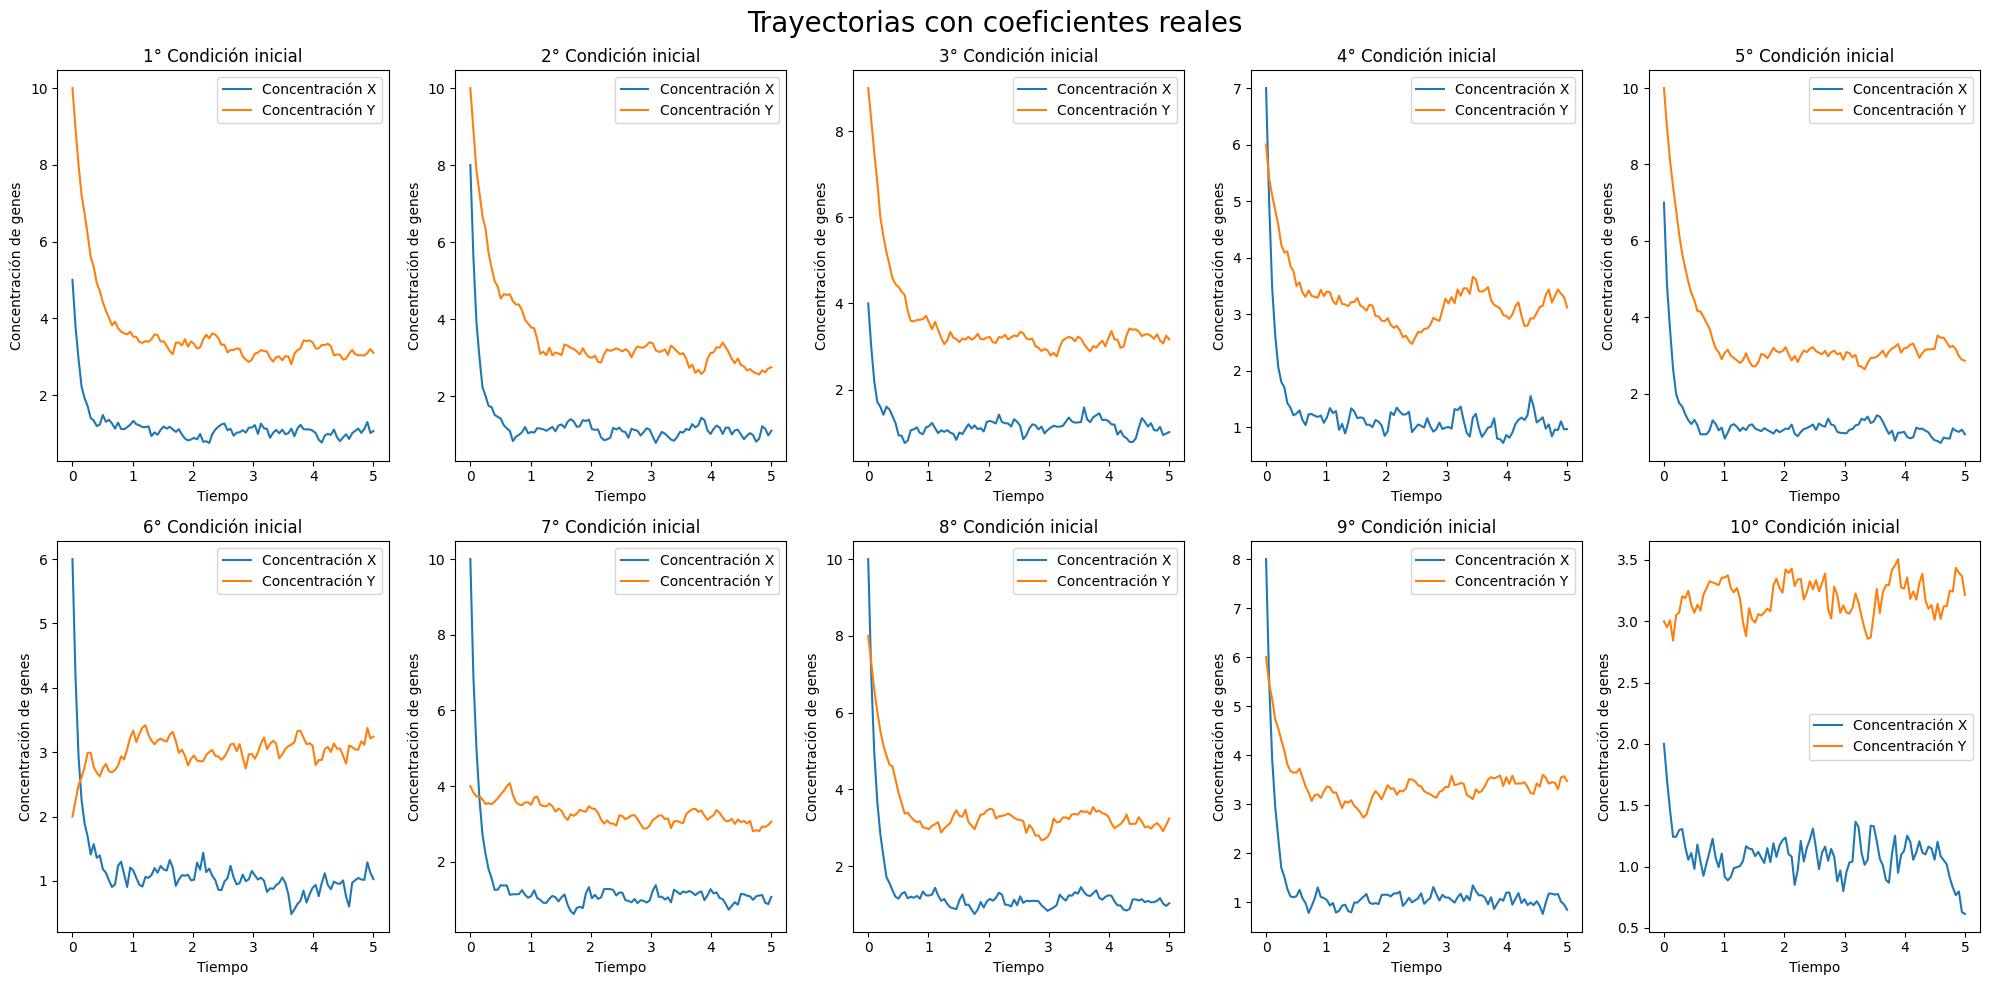

In [94]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [95]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

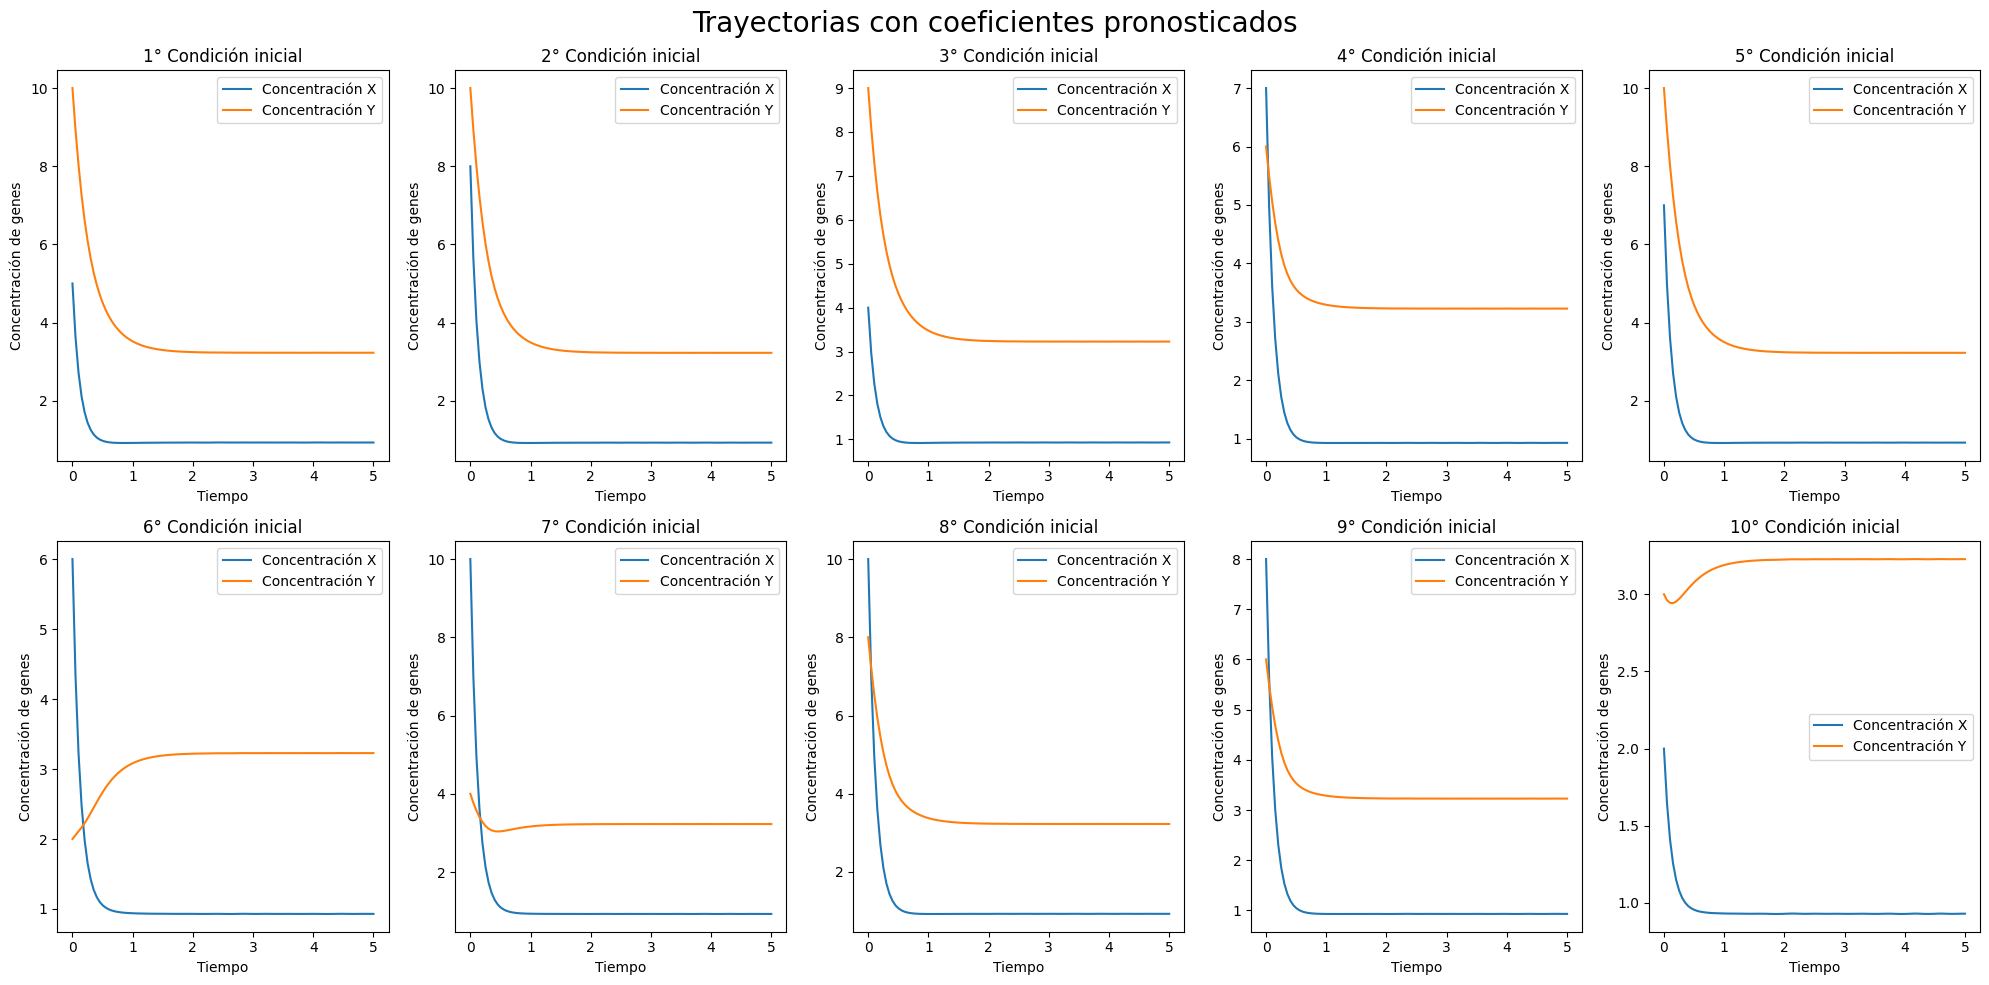

In [96]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

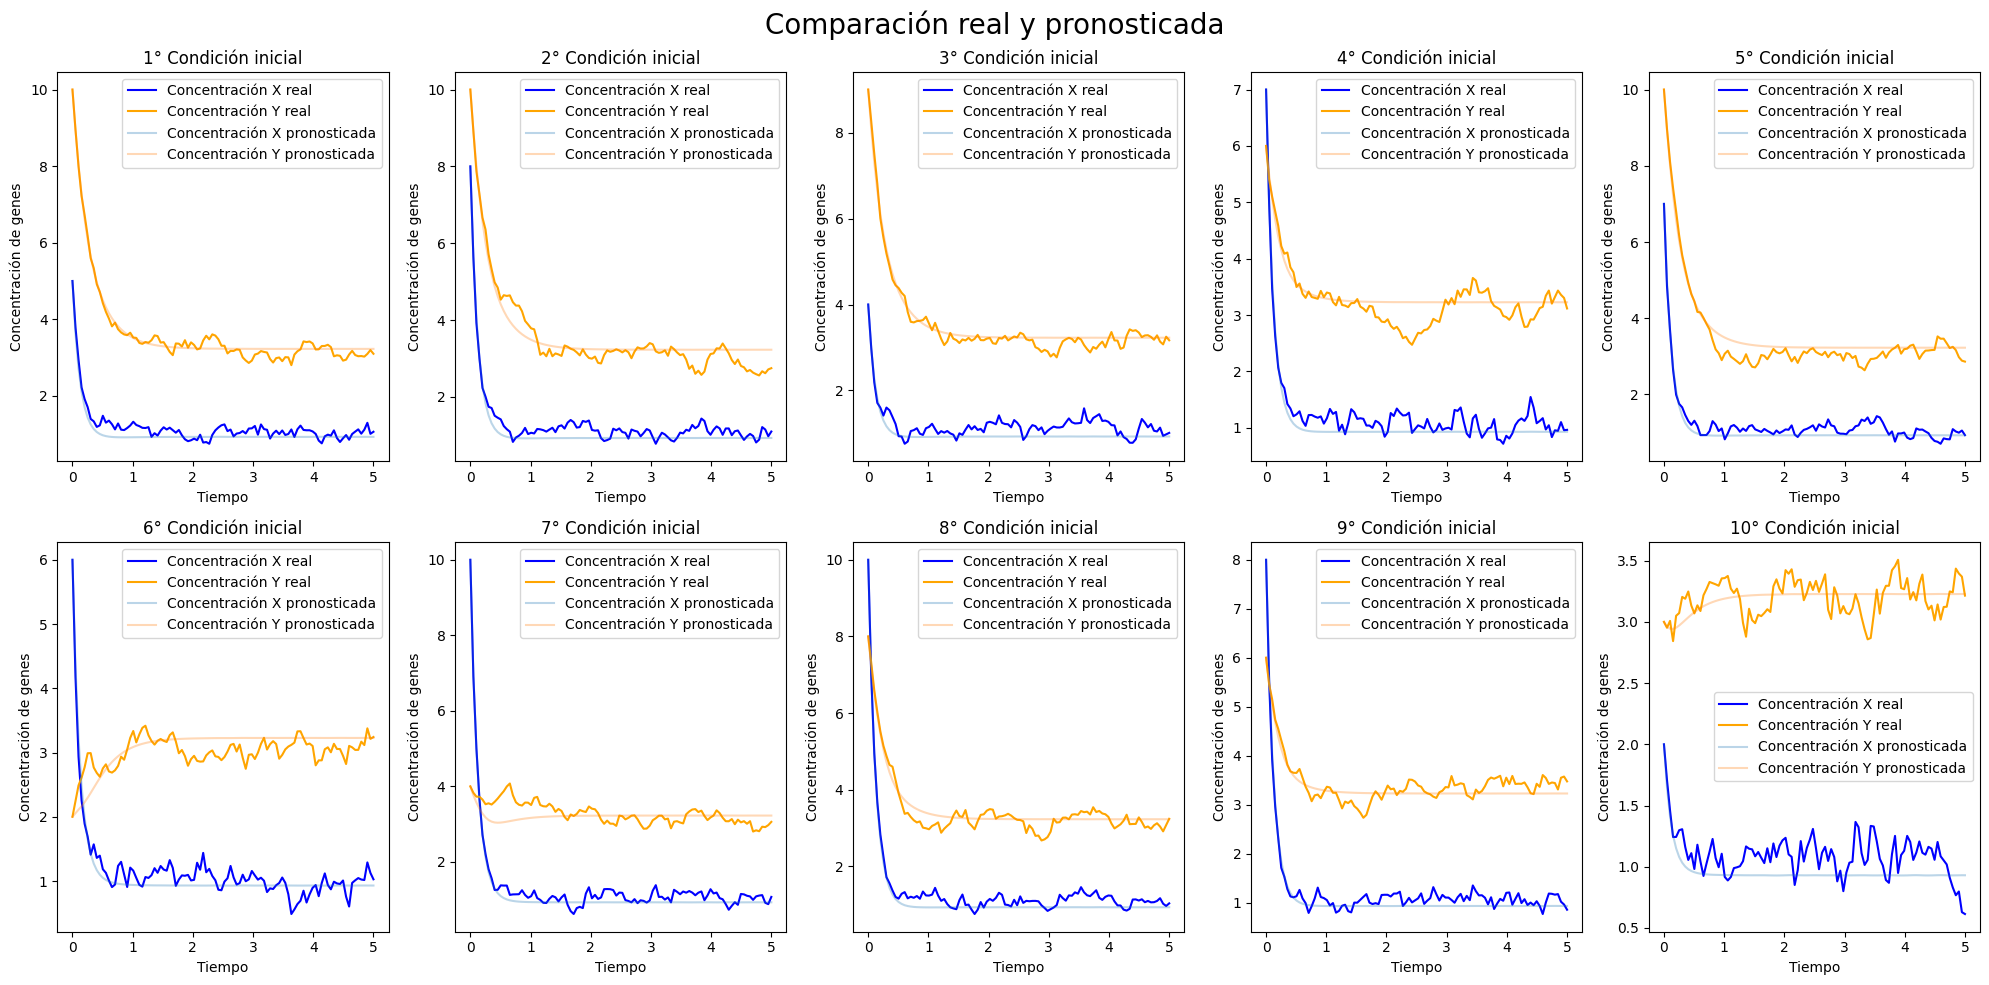

In [97]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

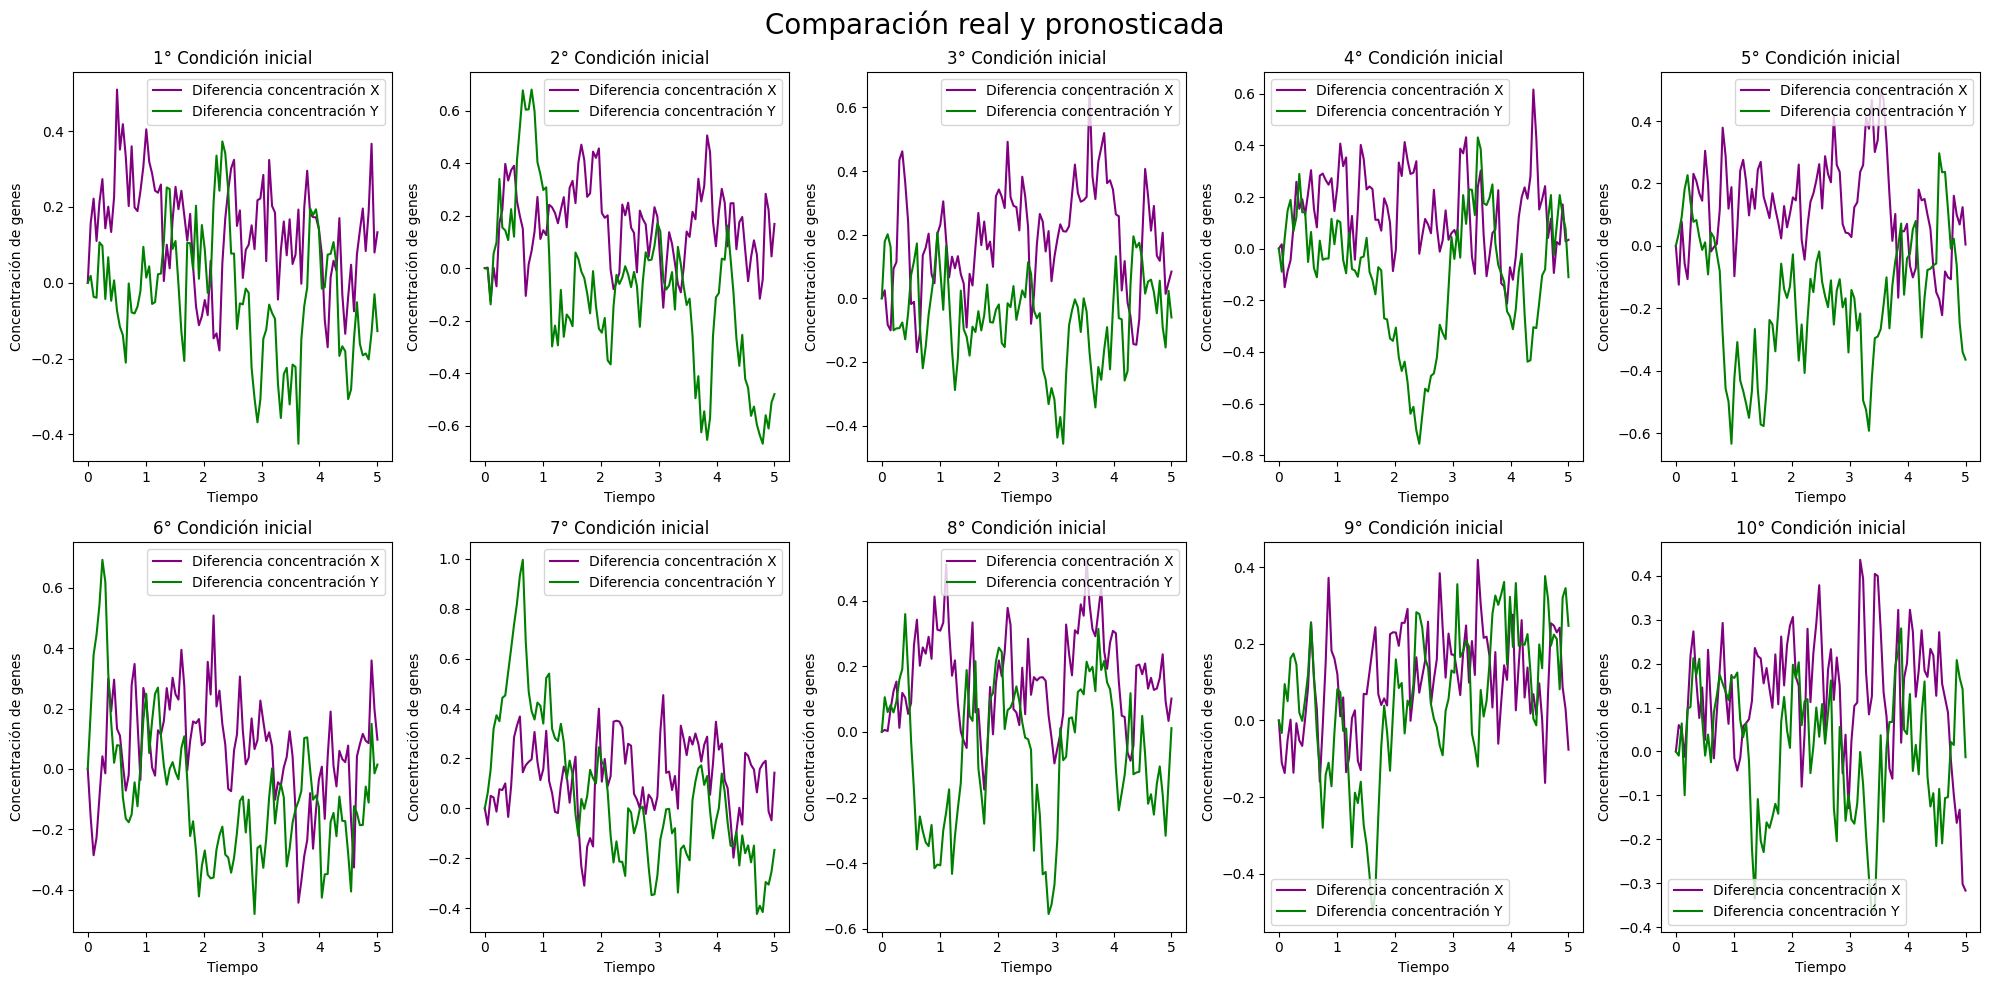

In [99]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [100]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.08366590588826202
0.08959478316740661
